In [ ]:
import os
import gc
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# check the version (should be 2.x+)
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.13.0


## Helper Functions

In [ ]:
# View an image
def read_image(target_dir):
  return mpimg.imread(target_dir)

def view_image(img, print_info=True):
  if print_info:
    print(f"Image shape: {img.shape} type: {type(img)}") # show the shape of the image

  plt.imshow(img)
  plt.axis("off")


# Increasing the shape of the image requires more RAM
def load(files, target_size, path):
  # Shuffle the data
  files = files.values

  array = []
  for fn in tqdm(files):
    img = load_img(os.path.join(path, fn), target_size=target_size)

    # Normalize the tensor
    img = img_to_array(img)/255.
    array.append(img)

  # Performs grabage collection to free up memory used by temporary objects
  gc.collect()
  return np.asarray(array)

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

def make_predictions(model, test_data):
  # Make predictions
  model_pred_probs = model.predict(test_data)

  # Get the index of the maximum probability in each sublist
  max_indices = np.argmax(model_pred_probs, axis=1)

  # Create an identity matrix with the number of columns equal to the number of classes
  identity_matrix = np.eye(len(model_pred_probs[0]))

  # Use fancy indexing to get the one-hot encoded vectors
  model_preds = identity_matrix[max_indices].astype(int)

  return model_preds

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

### Getting the data

In [ ]:
!pip install opendatasets
import opendatasets as od

# Download the dataset (note you will need an API)
od.download("https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets/data")

Skipping, found downloaded files in "./game-of-deep-learning-ship-datasets" (use force=True to force download)


In [ ]:
# Walk through the planesnet directory and list the number of files
for dirpath, dirnames, filenames in os.walk("game-of-deep-learning-ship-datasets"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 1 directories and 2 images in 'game-of-deep-learning-ship-datasets'
There are 1 directories and 1 images in 'game-of-deep-learning-ship-datasets/train'
There are 0 directories and 8932 images in 'game-of-deep-learning-ship-datasets/train/images'


In [ ]:
images = []
image_sizes = []

# define path for loading .jpg images
path = "./game-of-deep-learning-ship-datasets/"

# Read csv
train = pd.read_csv(path + "train/train.csv")
# test = pd.read_csv(path + "test_ApKoW4T.csv")

train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [ ]:
# display missing categories in train
train[train.isnull().any(axis=1)]

,image,category


In [ ]:
# dictionary ship encoding
ship = {'Cargo': 1,
        'Military': 2,
        'Carrier': 3,
        'Cruise': 4,
        'Tankers': 5}

# reverse the ship type dictionary
ship = dict([[v,k] for k,v in ship.items()])
ship

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}

In [ ]:
# Create test labels for interpretability
train['ship'] = train['category'].map(ship).astype('category')
labels = list(train['ship'].unique())
labels

['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers']

## Model Exploration

### Lets sample only 20% of the data

In [ ]:
# since training takes time and where just exploring the best model & hyper parameter
# lets sample only 20% of the data
train_20_percent = train.sample(frac=.2)
# test_20_percent = test.sample(frac=.2)

train_20_percent.head()

In [ ]:
# Split the train_20_percent data into train (80%), validation (10%), and test (10%) sets
train_df, temp_df = train_test_split(train_20_percent, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
df = train_20_percent

# Count the number of each classes in the 'train' DataFrame
wedge = [df['category'].value_counts()[1],
         df['category'].value_counts()[2],
         df['category'].value_counts()[3],
         df['category'].value_counts()[4],
         df['category'].value_counts()[5]]

# Get the percentages of each classes in the 'train' DataFrame
perc = [df['category'].value_counts()[1] / len(df),
        df['category'].value_counts()[2] / len(df),
        df['category'].value_counts()[3] / len(df),
        df['category'].value_counts()[4] / len(df),
        df['category'].value_counts()[5] / len(df)]

# Title
total_ships = sum(wedge)
title_text = f"Ship distribution (Total ships = {total_ships})"
plt.title(title_text, pad=100, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Labels and percentages
labels = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers']
formatted_perc = [f'{p * 100:.2f}%' for p in perc]
label_perc = [f'{label} - {p}' for label, p in zip(labels, formatted_perc)]

# Plot Pie chart
plt.pie(wedge, labels=label_perc, shadow=True, radius=2.0)

# Display the chart
plt.show()

### Data Processing (on 20% of the data)

In [ ]:
# Setup target directory (we'll view images from here)
target_dir = "./game-of-deep-learning-ship-datasets/train/images"

# Get samples of images
indexes = np.random.choice(len(train["ship"]), 10)

# Create subplots to see 28 images
plt.figure(figsize=(12, 5))

for i, index in enumerate(indexes):
  # Get filename
  fn = train_20_percent['image'].iloc[i]

  # Get image
  img = read_image(target_dir+'/'+fn)

  # Plot image
  plt.subplot(2, 5, i+1)
  plt.title(f'{train_20_percent["ship"].values[i]}')
  plt.imshow(img)
  plt.axis("off")

plt.show()

Our images have different shapes we need to augment the image so that they're the same shape

In [ ]:
# Setup target size
target_size = (224, 224)

# Preprocess the data
X_train = load(train_df["image"], target_size=target_size, path=target_dir)
X_valid = load(valid_df["image"], target_size=target_size, path=target_dir)
X_test = load(test_df["image"], target_size=target_size, path=target_dir)

X_train.shape, X_valid.shape, X_test.shape

Lets look at the preprocessed data

In [ ]:
# Get samples of images
indexes = np.random.choice(len(X_train), 10)

# Create subplots to see 28 images
plt.figure(figsize=(12, 5))

for i, index in enumerate(indexes):
  # Get image
  img = X_train[index, :, :, :]

  # Plot image
  plt.subplot(2, 5, i+1)
  plt.title(f'{train_20_percent["ship"].values[i]}')
  plt.imshow(img)
  plt.axis("off")

plt.show()

In [ ]:
# Encode train labels
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(dtype='int8', sparse_output=False)
y_train = ohe.fit_transform(train_df['category'].values.reshape(-1,1))
y_valid = ohe.fit_transform(valid_df['category'].values.reshape(-1,1))
y_test = ohe.fit_transform(test_df['category'].values.reshape(-1,1))

y_train.shape, y_valid.shape, y_test.shape

### Model 1: baseline model

We will create a CNN architecture same as Tiny VGG

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation="softmax") # binary activation output
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(X_train, y_train,
                        epochs=10,
                        steps_per_epoch=len(X_train),
                        validation_data=(X_valid, y_valid),
                        validation_steps=len(X_valid),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_1)

In [ ]:
# Test models performance
model_1_preds = make_predictions(model_1, X_test)

# Calculate model results
model_1_results = calculate_results(y_test, model_1_preds)
model_1_results

### Model 2: Tiny VGG with padding

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         padding="same",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu", padding="same"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="same"), # padding can also be 'same' or 'valid'
  tf.keras.layers.Conv2D(10, 3, activation="relu", padding="same"),
  tf.keras.layers.Conv2D(10, 3, activation="relu", padding="same"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation="softmax") # binary activation output
])

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(X_train, y_train,
                        epochs=10,
                        steps_per_epoch=len(X_train),
                        validation_data=(X_valid, y_valid),
                        validation_steps=len(X_valid),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_2)

In [ ]:
# Test models performance
model_2_preds = make_predictions(model_2, X_test)

# Calculate model results
model_2_results = calculate_results(y_test, model_2_preds)
model_2_results

### Model 3: Tiny VGG with filters

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation="softmax") # binary activation output
])

# Compile the model
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(X_train, y_train,
                        epochs=10,
                        steps_per_epoch=len(X_train),
                        validation_data=(X_valid, y_valid),
                        validation_steps=len(X_valid),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_3)

In [ ]:
# Test models performance
model_3_preds = make_predictions(model_3, X_test)

# Calculate model results
model_3_results = calculate_results(y_test, model_3_preds)
model_3_results

### Model 4: Data augmentation

Let's try with data augmentation but first we need to set it up.

In [ ]:
# Setup data augmentation
input_shape = (224, 224, 3)
num_classes = 5

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator()

# Train generator
train_data = train_datagen.flow(X_train, y_train, batch_size=32)

# Valid generator
valid_data = valid_datagen.flow(X_valid, y_valid, batch_size=32)

# Test generator
test_data = test_datagen.flow(X_test, y_test, batch_size=32)

Add the data augmentation with Tiny VGG!

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation="softmax") # binary activation output
])

# Compile the model
model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_4)

In [ ]:
# Test models performance
model_4_preds = make_predictions(model_4, X_test)

# Calculate model results
model_4_results = calculate_results(y_test, model_4_preds)
model_4_results

### Model 5: Transfer Learning (Mobilenet V3)

In [ ]:
# Load the pre-trained model from TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5"

# Download the pretrained model and save it as a Keras layer
base_model = hub.KerasLayer(model_url,
                            name='feature_extraction_layer',
                            input_shape=(224, 224, 3)) # define the input image shape

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Create model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)
output = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
model_5 = tf.keras.Model(inputs, output)

# Compile
model_5.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_5)

In [ ]:
# Test models performance
model_5_preds = make_predictions(model_5, X_test)

# Calculate model results
model_5_results = calculate_results(y_test, model_5_preds)
model_5_results

### Model 6: Transfer Learning with Finetuning (Mobilenet V3)

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Make the MobileNetV3 trainable
base_model.trainable = True

# Create model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)
output = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
model_6 = tf.keras.Model(inputs, output)

# Compile the model
model_6.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fine-tuning training
history_6 = model_6.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_6)

In [ ]:
# Test models performance
model_6_preds = make_predictions(model_6, X_test)

# Calculate model results
model_6_results = calculate_results(y_test, model_6_preds)
model_6_results

### Model 7: MobilenetV2 using "tf.keras.applications"

In [ ]:
# Use tf.keras.applications
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, input_tensor=None, weights='imagenet', include_top=False)

In [ ]:
# Create base model for feature extracion
tf.random.set_seed(42)
base_model.trainable = False

# Setup model input and outputs with data augmentation built-in
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(base_model.output)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_7 = tf.keras.Model(base_model.input, outputs)

# Compile Model
model_7.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Look at the models structutre

In [ ]:
# Visualize the model
plot_model(model_7, show_shapes=True, show_layer_names=True) # use, to_file='model_plot.png', if you want the image to be saved

In [ ]:
# Fine-tuning training
history_7 = model_7.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_7)

In [ ]:
# Test models performance
model_7_preds = make_predictions(model_7, X_test)

# Calculate model results
model_7_results = calculate_results(y_test, model_7_preds)
model_7_results

### Model 8: Fine tuning only the last 10 layers

Copying the baseline model for MobilenetV2 using "tf.keras.applications".

In [ ]:
# Freeze all layers except for the last 10
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Create base model for fine tuning
tf.random.set_seed(42)

# Setup model input and outputs with data augmentation built-in
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(base_model.output)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_8 = tf.keras.Model(base_model.input, outputs)

# Compile Model
model_8.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fine-tuning training
history_8 = model_8.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_8)

In [ ]:
# Test models performance
model_8_preds = make_predictions(model_8, X_test)

# Calculate model results
model_8_results = calculate_results(y_test, model_8_preds)
model_8_results

### Model 9: Fine tuning all layers

Copying the baseline model for MobilenetV2 using "tf.keras.applications".

In [ ]:
# Create base model for fine tuning
tf.random.set_seed(42)

# Unfreeze all layers
base_model.trainable = True

# Setup model input and outputs with data augmentation built-in
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(base_model.output)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_9 = tf.keras.Model(base_model.input, outputs)

# Compile Model
model_9.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fine-tuning training
history_9 = model_9.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

In [ ]:
plot_loss_curves(history_9)

In [ ]:
# Test models performance
model_9_preds = make_predictions(model_9, X_test)

# Calculate model results
model_9_results = calculate_results(y_test, model_9_preds)
model_9_results

### Evaluating all models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline_tiny_vgg": model_1_results,
                                  "tiny_vgg_with_padding": model_2_results,
                                  "tiny_vgg_more_filters": model_3_results,
                                  "tiny_vgg_data_augment": model_4_results,
                                  "mobilnetv3_feature_extract": model_5_results,
                                  "mobilenetv3_fine_tuning": model_6_results,
                                  "mobilenetv2_feature_extract": model_7_results,
                                  "mobilenetv2_fine_tuning_last_10": model_8_results,
                                  "mobilenetv2_fine_tuning_all": model_9_results})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Model Training

We will use MobilenetV3 for transfer learning and with fine tuning for this exercise.

## Preparing all data for training

In [ ]:
# Split the train_20_percent data into train (80%), validation (10%), and test (10%) sets
train_df, temp_df = train_test_split(train, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
df = train

# Count the number of each classes in the 'train' DataFrame
wedge = [df['category'].value_counts()[1],
         df['category'].value_counts()[2],
         df['category'].value_counts()[3],
         df['category'].value_counts()[4],
         df['category'].value_counts()[5]]

# Get the percentages of each classes in the 'train' DataFrame
perc = [df['category'].value_counts()[1] / len(df),
        df['category'].value_counts()[2] / len(df),
        df['category'].value_counts()[3] / len(df),
        df['category'].value_counts()[4] / len(df),
        df['category'].value_counts()[5] / len(df)]

# Title
total_ships = sum(wedge)
title_text = f"Ship distribution (Total ships = {total_ships})"
plt.title(title_text, pad=100, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Labels and percentages
labels = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers']
formatted_perc = [f'{p * 100:.2f}%' for p in perc]
label_perc = [f'{label} - {p}' for label, p in zip(labels, formatted_perc)]

# Plot Pie chart
plt.pie(wedge, labels=label_perc, shadow=True, radius=2.0)

# Display the chart
plt.show()

In [ ]:
# Setup target directory (we'll view images from here)
target_dir = "./game-of-deep-learning-ship-datasets/train/images"

# Get samples of images
indexes = np.random.choice(len(train["ship"]), 10)

# Create subplots to see 28 images
plt.figure(figsize=(12, 5))

for i, index in enumerate(indexes):
  # Get filename
  fn = train['image'].iloc[i]

  # Get image
  img = read_image(target_dir+'/'+fn)

  # Plot image
  plt.subplot(2, 5, i+1)
  plt.title(f'{train["ship"].values[i]}')
  plt.imshow(img)
  plt.axis("off")

plt.show()

Augment the images so that they're all the shame shape

In [ ]:
# Setup target size
target_size = (224, 224)

# Preprocess the data
X_train = load(train_df["image"], target_size=target_size, path=target_dir)
X_valid = load(valid_df["image"], target_size=target_size, path=target_dir)
X_test = load(test_df["image"], target_size=target_size, path=target_dir)

X_train.shape, X_valid.shape, X_test.shape

100%|██████████| 626/626 [00:00<00:00, 847.56it/s]


((5001, 224, 224, 3), (625, 224, 224, 3), (626, 224, 224, 3))

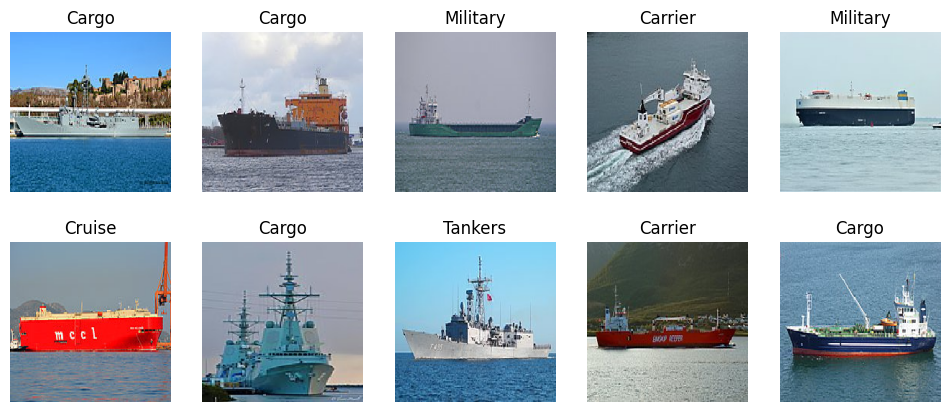

In [ ]:
# Get samples of images
indexes = np.random.choice(len(X_train), 10)

# Create subplots to see 28 images
plt.figure(figsize=(12, 5))

for i, index in enumerate(indexes):
  # Get image
  img = X_train[index, :, :, :]

  # Plot image
  plt.subplot(2, 5, i+1)
  plt.title(f'{train["ship"].values[i]}')
  plt.imshow(img)
  plt.axis("off")

plt.show()

In [ ]:
# Encode train labels
ohe = OneHotEncoder(dtype='int8', sparse_output=False)
y_train = ohe.fit_transform(train_df['category'].values.reshape(-1,1))
y_valid = ohe.fit_transform(valid_df['category'].values.reshape(-1,1))
y_test = ohe.fit_transform(test_df['category'].values.reshape(-1,1))

y_train.shape, y_valid.shape, y_test.shape

((5001, 5), (625, 5), (626, 5))

## Setup Data augmentation

In [ ]:
# Setup data augmentation
input_shape = (224, 224, 3)
num_classes = 5

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator()

# Train generator
train_data = train_datagen.flow(X_train, y_train, batch_size=32)

# Valid generator
valid_data = valid_datagen.flow(X_valid, y_valid, batch_size=32)

# Test generator
test_data = test_datagen.flow(X_test, y_test, batch_size=32)

## Setup basemodel

In [ ]:
# Load the pre-trained model from TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5"

# Download the pretrained model and save it as a Keras layer
base_model = hub.KerasLayer(model_url,
                            name='feature_extraction_layer',
                            input_shape=(224, 224, 3)) # define the input image shape

## Train model

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Make the MobileNetV3 trainable
base_model.trainable = True

# Create model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)
output = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, output)

# Compile the model
model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Look at the model architecture

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extraction_layer (  (None, 1001)              4013897   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 5)                 5010      
                                                                 
Total params: 4018907 (15.33 MB)
Trainable params: 3999819 (15.26 MB)
Non-trainable params: 19088 (74.56 KB)
_________________________________________________________________


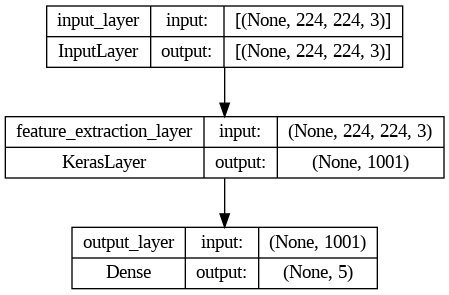

In [ ]:
# Visualize the model
plot_model(model, show_shapes=True, show_layer_names=True) # use, to_file='model_plot.png', if you want the image to be saved

In [ ]:
# Fine-tuning training
history = model.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=len(valid_data),
                      callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)])

Epoch 1/10
157/157 [==============================] - 128s 495ms/step - loss: 1.4883 - accuracy: 0.7760 - val_loss: 1.4368 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 2/10
157/157 [==============================] - 73s 466ms/step - loss: 1.0665 - accuracy: 0.8966 - val_loss: 1.1410 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 3/10
157/157 [==============================] - 73s 465ms/step - loss: 0.9578 - accuracy: 0.9292 - val_loss: 1.0491 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 4/10
157/157 [==============================] - 73s 464ms/step - loss: 0.9372 - accuracy: 0.9286 - val_loss: 1.0492 - val_accuracy: 0.9024 - lr: 0.0010
Epoch 5/10
157/157 [==============================] - 74s 474ms/step - loss: 0.8811 - accuracy: 0.9512 - val_loss: 0.9594 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 6/10
157/157 [==============================] - 75s 476ms/step - loss: 0.8485 - accuracy: 0.9530 - val_loss: 0.9800 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 7/10
157/157 [==============================]

## Evaluate performance

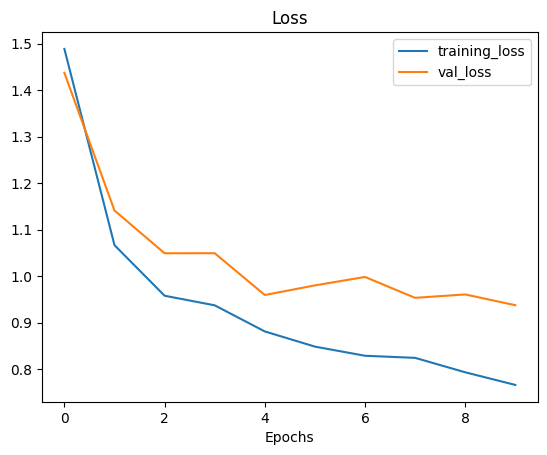

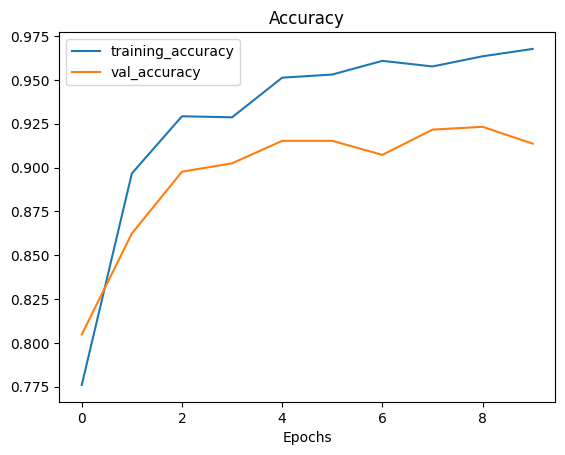

In [ ]:
plot_loss_curves(history)

In [ ]:
# Test models performance
model_preds = make_predictions(model, X_test)

# Calculate model results
model_results = calculate_results(y_test, model_preds)
model_results

20/20 [==============================] - 5s 207ms/step


{'accuracy': 90.73482428115017,
 'precision': 0.9110797215340606,
 'recall': 0.9073482428115016,
 'f1': 0.9082047429414394}

Save and evaluate the performance of the model.

This will be our baseline and will be compared to the converted TFLite model.

In [ ]:
# Setup the filename of the model
KERAS_MODEL_NAME = "tf_MobilenetV3_finetune.h5"

# Save the trained model
model.save(KERAS_MODEL_NAME)

# Display the size of the saved model
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


File size: 46.488 Megabytes


In [ ]:
# Save the byte equivalent size into a variable for future comparison
keras_model_size = get_file_size(KERAS_MODEL_NAME)

# Evaluate the models accuracy
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

20/20 - 1s - loss: 0.9766 - accuracy: 0.9073 - 862ms/epoch - 43ms/step

Test accuracy is 90.73%


#**TFLite**

## Initial conversion to TFLite


### **TFLite workflow**
1. Train a TensorFlow model
2. Convert to TensorFlow Lite format
3. Deploy and run on edge device

### Techniques for model compression
* **Quantization** - Paramter quantization takes an existing DNN and compresses its parameters by changing from floating-point numbers to low-bit width numbers. This avoids costly floating-point multiplications.
* **Pruning** - Pruning involves removing the least important paramteres (e.g. those that are close to 0).
* **Knowledge Distillation** - Creates a smaller DNN that imitates the behaviour of a larger, more powerful DNN. It approxiamtes the functions learned by a larger DNN by, training a smaller DNN using the output predictions from a larger DNN.

Note: pruning and qunatization can alos be considered jointly to further compress the model.

### **TFLite file format FlatBuffer**
FlatBuffers is an efficient cross platform serialization library for C++, C#, C, Go, Java, Kotlin, JavaScript, Lobster, Lue, TypeScript, PHP, Python, Rust and Swift. It was originally created at Google for game development and other performance-critical applications.

### **Why not use Protocol Buffers?**
Protocol Buffers is indeed realtively similar to FlatBuffers, with the primary difference being that **FlatBuffers does not need a parsing/unpacking step** to a secondary representation before you can access data, often coupled with per-object memory allocation. The code is an order of magnitude bigger, too.

In [ ]:
# Setup filename for TFLite model
TF_LITE_MODEL_FILE_NAME = "tf_lit_model.tflite"

# Initialize TFLite converter
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convet the model into TFLite
tflite_model = tf_lite_converter.convert()

# Save the model and model weights into a TFLite model file
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

16061136

In [ ]:
# Display the size of the TFLite converted model
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 15684.703 Kilobytes


In [ ]:
# Save the TFLite model into a variable
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

### Checking the converted TFLite Models performance

Were going to check if the TFLite model is still capable at classifying on unseen data similar in accuracy score to the TensorFlow model.

In [ ]:
# Check input and output tensor shapes of the TFLite mdoel
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

# From the shape our model is expecting 1 input at a time

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


#### Resize Tensor Shape

In [ ]:
test_df.shape

(626, 3)

In [ ]:
# How do I check how well it performs with 10,000 inputs?
# We need to resize the input and output tensor to the desired value
interpreter.resize_tensor_input(input_details[0]['index'], (626, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (626, 5))

# Once the tensors shape have changed we need to reallocate the tensor to restructure the intepreter
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [626 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [626   5]
Output Type: <class 'numpy.float32'>


In [ ]:
# Check the image data type
X_test.dtype

dtype('float32')

In [ ]:
# Change the data type of "float 64" to align with the input tensor data type of "float 32"
test_imgs_numpy = np.array(X_test, dtype=np.float32)
test_imgs_numpy.dtype

dtype('float32')

In [ ]:
# Making a prediciton/inference
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)

# Invoking the tesnor passes the input tensor to get the output tensor
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (626, 5)


In [ ]:
# The output is a probability score array
# We need to get the index of the class with the highest probability for all 10,000 images
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

In [ ]:
# Calculate the accuracy score of the predixctions
test_labels = np.argmax(y_test, axis=1)

acc = accuracy_score(prediction_classes, test_labels)
print('Test accuracy TFLite model is {}%'.format(round(100*acc, 2))) # note: accuracy is very similar to the original tensorflow model

Test accuracy TFLite model is 90.73%


In [ ]:
# Calculate the ratio of the space saved between the TFLite mdoel and the original tensorflow model
ratio_tflite = tflite_file_size/keras_model_size
print(f"Ratio (TFlite/Tensorflow): {ratio_tflite}")

Ratio (TFlite/Tensorflow): 0.3294834229453915


We are able to achieve similar performance while reducing the size of the model to fit to edge devices.

## TF Lite Model Float 16

We can compress the model even further without lossing much accuracy. We will convert the model from float32 to float16.

In [ ]:
# Setup filename for float16 conversion
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"

# Initialize converter and optimization
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set every weight value from float32 to float16
tf_lite_converter.target_spec.supported_types = [tf.float16]

# Convet the model
tflite_model = tf_lite_converter.convert()

In [ ]:
# Save the float16 model and weights into a TFLite model file
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model) # File size in bytes

8119132

In [ ]:
# Check the filesize
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 7928.84 Kilobytes


In [ ]:
# Calculate the ratio of the space saved between the TFLite float16 mdoel and the original tensorflow model
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)
print(f"Ratio (TFlite_float16/Tensorflow): {tflite_float_16_file_size/keras_model_size}")

Ratio (TFlite_float16/Tensorflow): 0.1665585424782819


In [ ]:
# Calculate the ratio of the space saved between the TFLite float16 mdoel and the inital TFLite model
print(f"Ratio (TFlite_float16/TFlite): {tflite_float_16_file_size/tflite_file_size}")

Ratio (TFlite_float16/TFlite): 0.5055141803170087


### Accuracy of the Quantized Model

#### Check Input Tensor Shape

In [ ]:
# Check input and output tensor shapes of the TFLite mdoel
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FLOAT_16_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

# From the shape our model is expecting 1 input at a time

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


#### Resize Tensor Shape

In [ ]:
# How do I check how well it performs with 10,000 inputs?
# We need to resize the input and output tensor to the desired value
interpreter.resize_tensor_input(input_details[0]['index'], (626, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (626, 5))

# Once the tensors shape have changed we need to reallocate the tensor to restructure the intepreter
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [626 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [626   5]
Output Type: <class 'numpy.float32'>


In [ ]:
# Test the accuracy of the TFLite quantized model
acc = accuracy_score(prediction_classes, test_labels)
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 90.73%


## TF Lite Size Quantized

We can compress the model even further without lossing much accuracy. We will use the technique call qunatization.

#####**What is Quantization?**
Quantization reduces the total number number of bits a models weights and activations. The overall arrays size is reduced.

In [ ]:
# Setup filename for float16 conversion
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

# Initialize converter and optimization
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

# TFLite will decide the optimal value for your models weights
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Convet the model
tflite_model = tf_lite_converter.convert()

In [ ]:
# Save the quantized model and weights into a TFLite model file
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

4332368

In [ ]:
# Check the filesize
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 4230.828 Kilobytes


In [ ]:
# Calculate the ratio of the space saved between the qunatized mdoel and the inital TF model
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
print(f"Ratio (TFLite_quantized/Tensorflow): {tflite_float_quant_file_size/keras_model_size}")

Ratio (TFLite_quantized/Tensorflow): 0.0888756211328439


In [ ]:
# Calculate the ratio of the space saved between the qunatized mdoel and the TFLite float16 model
print(f"Ratio (TFLite_quantized/TFLite_float16): {tflite_float_quant_file_size/ tflite_float_16_file_size}")

Ratio (TFLite_quantized/TFLite_float16): 0.5335998971318608


### Accuracy of the Quantized Model

#### Check Input Tensor Shape

In [ ]:
# Check input and output tensor shapes of the TFLite mdoel
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

# From the shape our model is expecting 1 input at a time

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float32'>


#### Resize Tensor Shape

In [ ]:
# How do I check how well it performs with 10,000 inputs?
# We need to resize the input and output tensor to the desired value
interpreter.resize_tensor_input(input_details[0]['index'], (626, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (626, 5))

# Once the tensors shape have changed we need to reallocate the tensor to restructure the intepreter
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [626 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [626   5]
Output Type: <class 'numpy.float32'>


In [ ]:
# Test the accuracy of the TFLite quantized model
acc = accuracy_score(prediction_classes, test_labels)
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 90.73%
